# EEG preprocessing 

## Imports

The data will be processed using the mne library. Also there are libraries made in eegyolk in order to load the metadata, eeg data and the event markers. Those libraries need to be imported

In [1]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, 'C:\Projects\ePodium\eegyolk') # path to helper functions
from eegyolk import helper_functions as hf # library useful for eeg and erp data cleaning
from eegyolk import initialization_functions #library to import data
from eegyolk import epod_helper

## Load metadata and eeg files

First the different pathways for the different datasets need to be defined. There are three pathways: eeg, metadata and events. The files can be loaded using the initialization_functions library. All event markers needs to be saved in a seperate folder. If not saved already, the event markers will be saved using the initialization_function library. 

In [2]:
# define pathways
path_eeg = os.path.join("F:", os.sep, "Stage", "ePODIUM", "Data", "not_zip")
path_metadata = os.path.join("F:", os.sep, "Stage", "ePODIUM", "Data", "metadata")
path_eventmarkers = os.path.join("F:", os.sep, "Stage", "ePODIUM", "Data", "not_zip", "event_markers")

# load metadata and eeg
files_metadata = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
children, cdi, parents, codes = initialization_functions.load_metadata(path_metadata, files_metadata) # load metadata
eeg, eeg_filenames, eeg_filepaths = initialization_functions.load_dataset(path_eeg) # load eeg

# load events 
events_files = os.listdir(path_eventmarkers)
if len(events_files) == 0 or path_eventmarkers == False: # check if event markers are saved in a seperate folder
    initialization_functions.save_event_markers(path_eventmarkers, eeg, eeg_filenames) # save event markers
    
event_markers = initialization_functions.load_event_markers(path_eventmarkers, eeg_filenames) # load event markers
event_markers_simplified = epod_helper.group_event_markers(event_markers) # simplify events


99 EEG files loaded
99 Event Marker files loaded


## Data info

Choose which participant you want to view in the box below. 

In [3]:
index = widgets.IntText(
    step=0.1,
    description='Participant',
    disabled=False
)
widgets.VBox([index])

In [4]:
index = int(index.value)

In [5]:
print("\n", eeg[index].info)


 <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2021-03-01 09:29:57 UTC
 nchan: 41
 projs: []
 sfreq: 2048.0 Hz
>


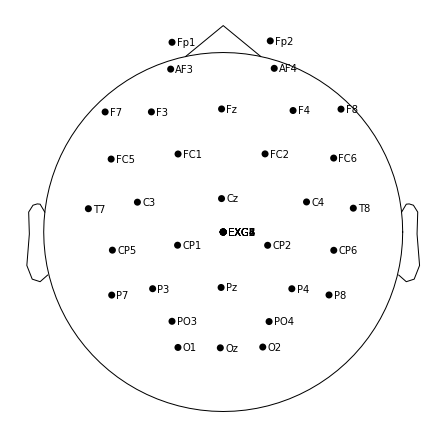

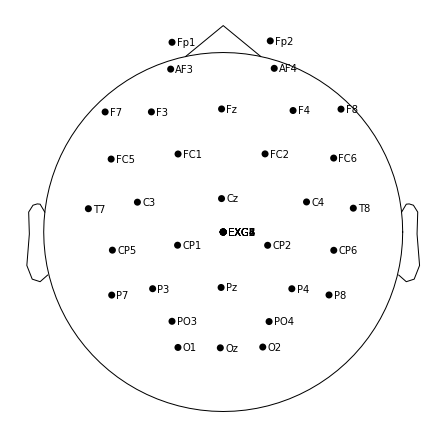

In [6]:
# plot of the used sensors
montage = mne.channels.make_standard_montage('standard_1020')
#montage.plot(kind='topomap', show_names=True)
eeg[index].info.set_montage(montage, on_missing='ignore')
eeg[index].plot_sensors(ch_type='eeg', show_names=True)

Using matplotlib as 2D backend.
Opening raw-browser...


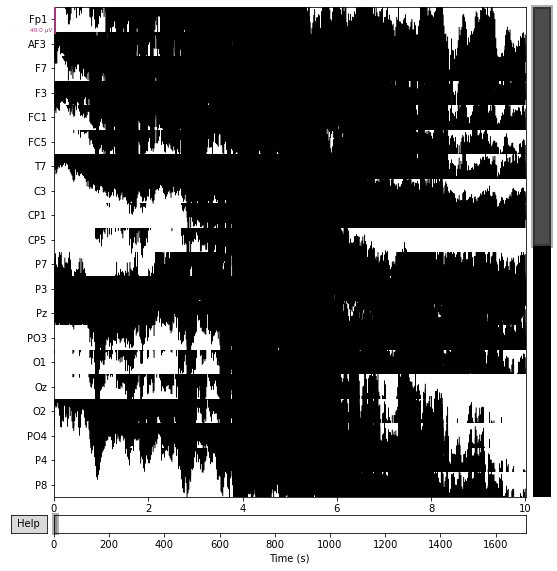

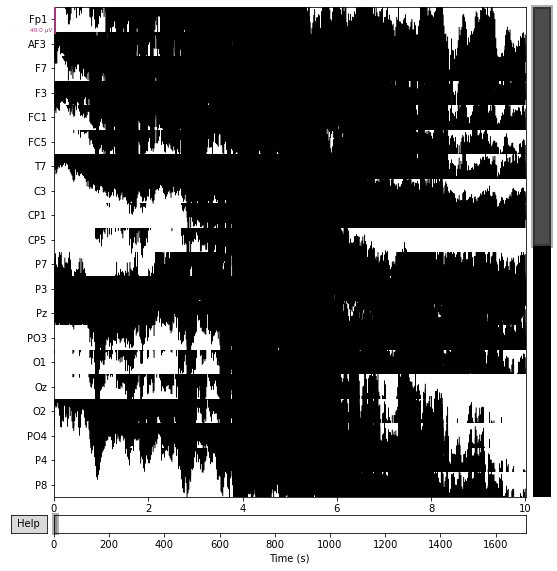

In [7]:
eeg[index].plot()

<ipython-input-8-39cc3f276206>:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)


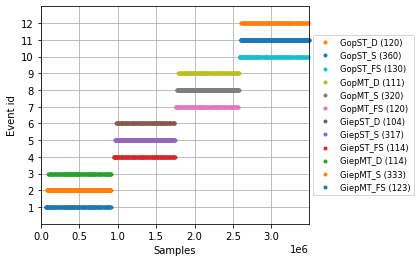

In [8]:
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)

## Filtering

In [9]:
# bad channel remover
def removebadchannel(eeg):
    for i in range(len(eeg)):
        if len(eeg[i].info['bads']) != 0:
            eeg[index] = mne.pick_types(eeg[i].info, meg=False, eeg=True, exclude='bads')
    return eeg
removebadchannel(eeg)

[<RawEDF | 101a.bdf, 41 x 3497984 (1708.0 s), ~56 kB, data not loaded>,
 <RawEDF | 101b.bdf, 41 x 3907584 (1908.0 s), ~43 kB, data not loaded>,
 <RawEDF | 102a.bdf, 41 x 3815424 (1863.0 s), ~43 kB, data not loaded>,
 <RawEDF | 102b.bdf, 41 x 3782656 (1847.0 s), ~43 kB, data not loaded>,
 <RawEDF | 103a.bdf, 41 x 3899392 (1904.0 s), ~43 kB, data not loaded>,
 <RawEDF | 103b.bdf, 41 x 4294656 (2097.0 s), ~43 kB, data not loaded>,
 <RawEDF | 104a.bdf, 41 x 3790848 (1851.0 s), ~43 kB, data not loaded>,
 <RawEDF | 104b.bdf, 41 x 3794944 (1853.0 s), ~43 kB, data not loaded>,
 <RawEDF | 105a.bdf, 41 x 4282368 (2091.0 s), ~43 kB, data not loaded>,
 <RawEDF | 105b.bdf, 41 x 3852288 (1881.0 s), ~43 kB, data not loaded>,
 <RawEDF | 106a.bdf, 41 x 3215360 (1570.0 s), ~43 kB, data not loaded>,
 <RawEDF | 106b.bdf, 41 x 3788800 (1850.0 s), ~43 kB, data not loaded>,
 <RawEDF | 107a.bdf, 41 x 4063232 (1984.0 s), ~43 kB, data not loaded>,
 <RawEDF | 107b (deel 1+2).bdf, 41 x 1882112 (919.0 s), ~43 kB, 

In [10]:
lowpass = widgets.IntText(
    step=0.1,
    description='lowpass:',
    disabled=False
)

highpass = widgets.IntText(
    step=0.1,
    description='highpass:',
    disabled=False
)

widgets.VBox([lowpass,highpass])


In [11]:
# change type to integer
lowpass = int(lowpass.value)
highpass = int(highpass.value)

Bandpass filter doesn't work due to memory issues. Can be fixed with preload = True in the load_data() in helper_functions.py. However, jupyter crashes due to lack of memory when done. Needs to be fixed.

In [13]:
# bandpass filter
for index in range(len(eeg)): eeg[index] = hf.band_pass_filter(eeg[index], lowpass, highpass)

RuntimeError: By default, MNE does not load data into main memory to conserve resources. inst.filter requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

Below a working filter, but not imported from helper_functions.py. This is a band pass filter with defined frequency. The filter is useful for limitting the bandwidth of the output signal to avoid noise. 

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 sec)



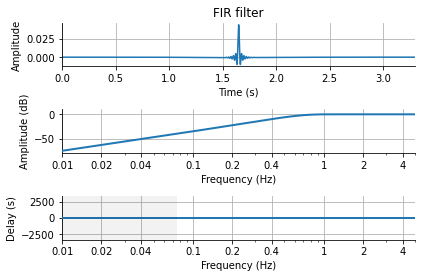

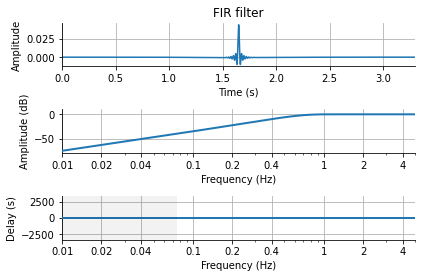

In [14]:
# plotting filter
filter_params = mne.filter.create_filter(eeg[index].get_data(), eeg[index].info['sfreq'],
                                         l_freq=lowpass, h_freq=highpass)
mne.viz.plot_filter(filter_params, eeg[index].info['sfreq'], flim=(0.01, 5))

The data contains power line noise which disrupts the rest of the signal. The notch filter filters out the fequency of 50 Hz. Does not work because of the preload memory issue. 

In [15]:
# create notch filter
freqs = (60, 120, 180, 240)
for i in range(len(eeg)): eeg[i] = eeg[i].notch_filter(freqs=freqs)

RuntimeError: By default, MNE does not load data into main memory to conserve resources. raw.notch_filter requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

## Creating epoched data

Epochs are created with joining the eeg data with a specific event. tmin and tmax are the start and stop time relative to each event. mne.Epochs automaticaly create a baseline correction.

In [45]:
def create_epochs(eeg, event_markers_simplified):
    epochs =  []
    for i in range(len(eeg)): 
        single_epoch = mne.Epochs(eeg[i], event_markers_simplified[i], tmin=-0.3, tmax=0.7)
        epochs.append(single_epoch)
    return epochs

epochs = create_epochs(eeg, event_markers_simplified)

Not setting metadata
2266 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2389 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2208 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2521 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mod

Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2471 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [46]:
print(epochs)

[<Epochs |  2266 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~56 kB, data not loaded,
 '1': 123
 '2': 333
 '3': 114
 '4': 114
 '5': 317
 '6': 104
 '7': 120
 '8': 320
 '9': 111
 '10': 130
 and 2 more events ...>, <Epochs |  2440 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~43 kB, data not loaded,
 '1': 130
 '2': 360
 '3': 120
 '4': 130
 '5': 360
 '6': 120
 '7': 130
 '8': 360
 '9': 120
 '10': 130
 and 2 more events ...>, <Epochs |  2389 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~43 kB, data not loaded,
 '1': 130
 '2': 360
 '3': 120
 '4': 119
 '5': 331
 '6': 109
 '7': 130
 '8': 360
 '9': 120
 '10': 130
 and 2 more events ...>, <Epochs |  2440 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~43 kB, data not loaded,
 '1': 130
 '2': 360
 '3': 120
 '4': 130
 '5': 360
 '6': 120
 '7': 130
 '8': 360
 '9': 120
 '10': 130
 and 2 more events ...>, <Epochs |  2208 events (good & 

In [47]:
epochs[index].plot(n_epochs=1)

Loading data for 2266 events and 2049 original time points ...
0 bad epochs dropped
Opening epochs-browser...


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002333761C3A0> (for post_execute):


KeyboardInterrupt: 

Below the average epoch for each event time is plotted over all channels.

In [ ]:
for i in range(len(epod_helper.event_dictionary)):
    evoked = epochs[i].average()
    evoked.plot()
    #print(epod_helper.event_dictionary.keys(i))
    print(([key for key in epod_helper.event_dictionary.keys()][i], [value for value in epod_helper.event_dictionary.values()][i])) 

In [ ]:
epochs = epochs[0:4] # subset to test function
def create_pd_df(epochs):
    df_epochs = pd.DataFrame()

    for i in range(len(epochs)):
        df = epochs[i].to_data_frame()
        df['index'] = i
        df_epochs = df_epochs.append(df)
    return df_epochs

create_pd_df(epochs)

In [ ]:
df_epochs